In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/my_model/tensorflow2/default/1/Sent_model/Model/config.json
/kaggle/input/my_model/tensorflow2/default/1/Sent_model/Model/tf_model_new.h5
/kaggle/input/my_model/tensorflow2/default/1/Sent_model/Tokenizer/tokenizer_config.json
/kaggle/input/my_model/tensorflow2/default/1/Sent_model/Tokenizer/vocab.txt
/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv


In [2]:
import matplotlib.pyplot as plt

In [3]:
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import logging, TFBertForSequenceClassification, AdamW, BertConfig, BertTokenizer, get_linear_schedule_with_warmup
import tensorflow as tf 

In [6]:
logging.set_verbosity_error()

In [7]:
stop_words = stopwords.words('english')

In [8]:
train = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv', encoding='latin1')
test = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/test.csv', encoding='latin1')

In [9]:
train.head(10)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,night,70-100,Antigua and Barbuda,97929,440.0,223
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,morning,0-20,Argentina,45195774,2736690.0,17
7,50e14c0bb8,Soooo high,Soooo high,neutral,noon,21-30,Armenia,2963243,28470.0,104
8,e050245fbd,Both of you,Both of you,neutral,night,31-45,Australia,25499884,7682300.0,3
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,morning,46-60,Austria,9006398,82400.0,109


In [12]:
train.loc[:, ['text', 'sentiment']].head(10)

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
5,http://www.dothebouncy.com/smf - some shameles...,neutral
6,2am feedings for the baby are fun when he is a...,positive
7,Soooo high,neutral
8,Both of you,neutral
9,Journey!? Wow... u just became cooler. hehe....,positive


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [31]:
train.isnull().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [32]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [33]:
sent_freq = train['sentiment'].value_counts()
sent_cat = train['sentiment'].unique()

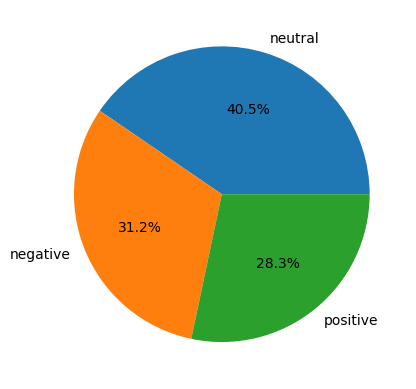

In [34]:
plt.pie(sent_freq, labels=sent_cat, autopct='%1.1f%%')
plt.show()

In [35]:
train_df = train[['text', 'sentiment']].copy()
test_df = test[['text', 'sentiment']].copy()

In [36]:
class text_preprocessing:
    def __init__(self, stemming=False, Lemmatisation=False):
        self.stemming = stemming
        self.Lemmatisation = Lemmatisation
        
        if self.stemming:
            self.stemmer = PorterStemmer()
        elif self.Lemmatisation:
            self.lemmatizer = WordNetLemmatizer()
        else:
            pass
        
        self.stopwords_modified = stop_words + ["soo", "ooh", "god", "wow", "lol", "also"]
        self.auxiliary_verbs = {"wasn", "weren", "hasn", "haven", "hadn", "isn",
                                "aren", "doesn", "didn", "can", "couldn", "wouldn",
                                "shouldn", "mightn", "mustn", 'not', 'no'}
        self.stopwords_set = set(self.stopwords_modified) - self.auxiliary_verbs
    def clean(self, text):
        text = text.lower() #make the text lowercase
        text = re.sub(r'https?://\S+|www\.\S+', '', text) #remove url
        text = re.sub(r'<.*?>', '', text) #remove html tags
        text = re.sub(r'\b(\w*)`(\w*)\b', r"\1'\2", text) #make sure of all negation with '
        text = re.sub(r"\b(\w+)n't\b", r"\1 not",text) #replace all negation with not
        text = re.sub(r'[^a-z\s]', ' ', text) # Remove punctuation and special characters
        text = re.sub(r'\b[a-zA-Z]\b', '', text) #remove single charaters with no meaning
        text = re.sub(r'\n', '', text) #remove newline
        text = re.sub(r'(.)\1+', r'\1\1', text) #remove duplicate letters
        text = re.sub(r'\b\w*\d\w*\b', '', text) #remove words in franco and digits
        
        #Remove stop words
        BOW = nltk.word_tokenize(text)
        stopwords_removed = [word for word in BOW if word not in self.stopwords_set] 
        
        if self.stemming:
            text = [self.stemmer.stem(word) for word in stopwords_removed]
        elif self.Lemmatisation:
            text = [self.lemmatizer.lemmatize(word,pos='v') for word in stopwords_removed]
        else:
            pass        
        
        text = ' '.join(text)
        #replace i with y in verbs 
#         text = re.sub(r"\b(\w+)i\b", r"\1y",text)
        return text

In [37]:
preprocess = text_preprocessing(Lemmatisation=True)
train_df['text'] = train_df['text'].apply(lambda x: preprocess.clean(x))
test_df['text'] = test_df['text'].apply(lambda x: preprocess.clean(x))

In [38]:
train_df.head(10)

,text,sentiment
0,respond go,neutral
1,sad miss san diego,negative
2,boss bully,negative
3,interview leave alone,negative
4,sons could not put release already buy,negative
5,shameless plug best rangers forum earth,neutral
6,feed baby fun smile coo,positive
7,high,neutral
8,,neutral
9,journey become cooler hehe possible,positive


In [39]:
test_df.head(10)

,text,sentiment
0,last session day,neutral
1,shanghai really excite precisely skyscrapers g...,positive
2,recession hit veronique branquinho quit compan...,negative
3,happy bday,positive
4,like,positive
5,great wee visitors,positive
6,think everyone hat,negative
7,wish could im school myspace completely block,negative
8,within short time last clue,neutral
9,get day alright not do anything yet leave soon...,neutral


In [40]:
category_encoding = {"neutral":0, "positive":1, "negative":2}
train_df['sentiment'] = train_df['sentiment'].map(category_encoding)
test_df['sentiment'] = test_df['sentiment'].map(category_encoding)

In [41]:
X, y = train_df['text'], train_df['sentiment']
X_train, X_valid, y_train, y_valid = train_test_split(X,y, train_size=0.8, 
                                                     random_state=42,
                                                     shuffle=True, stratify=y)
X_test , y_test = test_df['text'], test_df['sentiment']

In [42]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [43]:
def get_max_length(texts):
    max_len = 0
    # For every sentence
    for sent in texts:

        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.encode(sent, add_special_tokens=True)

        # Update the maximum sentence length.
        max_len = max(max_len, len(input_ids))

    return max_len

df = pd.concat([train_df['text'], test_df['text']])
max_len = get_max_length(df.values)

In [44]:
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(X_train.tolist(),
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
X_val_encoded = tokenizer.batch_encode_plus(X_valid.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
X_test_encoded = tokenizer.batch_encode_plus(X_test.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

In [45]:
print(X_train_encoded.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [46]:
k = 0
print('Training Comments -->>',X_train[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])

Training Comments -->> respond go

Input Ids -->>
 tf.Tensor(
[  101  4067  4950  8081  2215  2047 26322   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0], shape=(42,), dtype=int32)

Decoded Ids -->>
 [CLS] thank camera fix want new ipod [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Attention Mask -->>
 tf.Tensor(
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0], shape=(42,), dtype=int32)


In [102]:
# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    
    patience=3,            
    restore_best_weights=True,  
    mode='min'             
)

In [47]:
#To avoid overfitting
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=3)
config.hidden_dropout_prob = 0.2  
config.attention_probs_dropout_prob = 0.2  

In [48]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',config = config)

In [105]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [106]:
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    y_train,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],
    y_valid),
    batch_size=32,
    epochs = 10,
    callbacks=[early_stopping])

Epoch 1/10
687/687 [==============================] - 268s 307ms/step - loss: 0.7256 - accuracy: 0.6768 - val_loss: 0.6012 - val_accuracy: 0.7422
Epoch 2/10
687/687 [==============================] - 201s 292ms/step - loss: 0.5589 - accuracy: 0.7781 - val_loss: 0.5976 - val_accuracy: 0.7591
Epoch 3/10
687/687 [==============================] - 200s 292ms/step - loss: 0.5042 - accuracy: 0.8015 - val_loss: 0.5931 - val_accuracy: 0.7556
Epoch 4/10
687/687 [==============================] - 199s 290ms/step - loss: 0.4453 - accuracy: 0.8299 - val_loss: 0.6553 - val_accuracy: 0.7649
Epoch 5/10
687/687 [==============================] - 207s 301ms/step - loss: 0.3903 - accuracy: 0.8501 - val_loss: 0.6327 - val_accuracy: 0.7631
Epoch 6/10
687/687 [==============================] - 200s 291ms/step - loss: 0.3298 - accuracy: 0.8758 - val_loss: 0.6808 - val_accuracy: 0.7642


In [107]:
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

111/111 [==============================] - 21s 79ms/step - loss: 0.5828 - accuracy: 0.7564
Test loss: 0.5828179717063904, Test accuracy: 0.7563667297363281


In [108]:
# Define the path for saving in Kaggle environment
path = '/kaggle/input/my_model/tensorflow2/default/1/Sent_model'

# Create the directory if it doesn't exist
os.makedirs(path, exist_ok=True)

# Save tokenizer
tokenizer.save_pretrained(os.path.join(path, 'Tokenizer'))

# Save model
model.save_pretrained(os.path.join(path, 'Model'))

In [79]:
# Define the path to your tokenizer and model
path = '/kaggle/input/my_model/tensorflow2/default/1/Sent_model'

# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(os.path.join(path, 'Tokenizer'))

# Initialize a model with the same architecture (use the same version of BERT you trained with)
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config = config)

# Load weights from your custom .h5 file
model_weights_path = os.path.join(path, 'Model', 'tf_model_new.h5')  # replace with your actual file name
bert_model.load_weights(model_weights_path)

In [80]:
predictions = bert_model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

logits = predictions.logits

111/111 [==============================] - 25s 82ms/step


In [81]:
pred_labels = tf.argmax(logits, axis=1).numpy()

In [82]:
label = {0:"neutral", 1:"positive", 2:"negative"}
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]
 
print('Predicted Label :', pred_labels[:10])
print('Actual Label    :', Actual[:10])

Predicted Label : ['neutral', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'neutral', 'neutral', 'neutral']
Actual Label    : ['neutral', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'neutral', 'neutral']


In [83]:
print("Classification Report: \n", classification_report(Actual, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.71      0.82      0.76      1001
     neutral       0.75      0.66      0.71      1430
    positive       0.80      0.82      0.81      1103

    accuracy                           0.76      3534
   macro avg       0.76      0.77      0.76      3534
weighted avg       0.76      0.76      0.75      3534



In [84]:
def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
    # Convert Review to a list if it's not already a list
    if not isinstance(Review, list):
        Review = [Review]
 
    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
                                                                             padding=True,
                                                                             truncation=True,
                                                                             max_length=max_len,
                                                                             return_tensors='tf').values()
    prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])
 
    # Use argmax along the appropriate axis to get the predicted labels
    pred_labels = tf.argmax(prediction.logits, axis=1)
 
    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
    return pred_labels

In [86]:
Review ="I like eating pizza"
Get_sentiment(Review)

1/1 [==============================] - 0s 54ms/step


['positive']